In [27]:
from gtda.homology import EuclideanCechPersistence,VietorisRipsPersistence
from gtda.diagrams import PersistenceImage
from gtda.pipeline import Pipeline
from gtda.diagrams import Filtering

In [28]:
import tensorflow as tf
import gudhi as gd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import utils
import scipy.spatial as spatial
import json
from rich import print
from random import choice, sample
from tqdm.notebook import tqdm
from rdkit import Chem
from rdkit.Chem import Descriptors
from gc import collect
from pickle import load

with open("cech_persistence_images_012_20bins.pickle", mode = "rb") as data:
    save_dict = load(data)
    train_molecules = save_dict["train_molecules"]
    train_data = save_dict["train_data"]
    
    test_molecules = save_dict["test_molecules"]
    test_data = save_dict["test_data"]
    
%matplotlib inline
del save_dict
collect()

119

In [29]:
print(train_data.shape, test_data.shape)

(7761, 9, 20, 20)
(1940, 9, 20, 20)

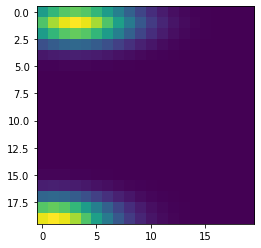

In [30]:
plt.imshow(train_data[19,7])

# Extract descriptors
(this can be done from rdkit or from the descriptor .csv)

In [31]:
df = pd.read_csv("data/Drugbank_some_descriptors.csv")

### Filter descriptors which are unavailable

In [32]:
descriptors = list()

# consider only descriptors which have few missing values and which are floating point
for d in df:
    if df[d].isna().sum() < 800 and df[d].dtype == np.float64:
        descriptors.append(d)

num_descriptors = len(descriptors)
print(descriptors)

# select only smiles which have these descriptor values
train_smiles = set(train_molecules)
test_smiles = set(test_molecules)

for i,d in enumerate(descriptors):
    avail_rows = df[np.logical_not(df[d].isna())]
    train_smiles = set(avail_rows["SMILES"]).intersection(train_smiles)
    test_smiles = set(avail_rows["SMILES"]).intersection(test_smiles)

train_idxs = np.asarray(sorted([ train_molecules.index(t) for t in train_smiles ]))
test_idxs = np.asarray(sorted([ test_molecules.index(t) for t in test_smiles ]))

train_molecules = np.asarray(train_molecules)
train_molecules = train_molecules[train_idxs]
train_data = train_data[train_idxs]

test_molecules = np.asarray(test_molecules)
test_molecules = test_molecules[test_idxs]
test_data = test_data[test_idxs]

[
    'ACD Descriptors;logP',
    'ACD logD-logP;logP',
    'MOE Descriptors;h_ema',
    'MOE Descriptors;h_emd',
    'MOE Descriptors;h_emd_c',
    'MOE Descriptors;h_logp',
    'MOE Descriptors;h_logs',
    'MOE Descriptors;h_log_dbo',
    'MOE Descriptors;h_log_pbo',
    'MOE Descriptors;h_mr',
    'OEselma Descriptors;bromine_count',
    'OEselma Descriptors;carbon_count',
    'OEselma Descriptors;clorine_count',
    'OEselma Descriptors;ertl_tpsa',
    'OEselma Descriptors;fluorine_count',
    'OEselma Descriptors;hba',
    'OEselma Descriptors;hba_lipinski',
    'OEselma Descriptors;hbd',
    'OEselma Descriptors;hbd_lipinski',
    'OEselma Descriptors;halogen_count',
    'OEselma Descriptors;iodine_count',
    'OEselma Descriptors;max_flex_chain_1',
    'OEselma Descriptors;max_flex_chain_2',
    'OEselma Descriptors;max_flex_chain_3',
    'OEselma Descriptors;max_rigid_chain',
    'OEselma Descriptors;mol_volume_2d',
    'OEselma Descriptors;mw',
    'OEselma Descriptors;npsa',
    'OEselma Descriptors;neg_ioniz',
    'OEselma Descriptors;nitrogen_count',
    'OEselma Descriptors;nonpolar_count',
    'OEselma Descriptors;nonpolar_count_per_mw',
    'OEselma Descriptors;rigid_frag_count',
    'OEselma Descriptors;aromatic_ring_count',
    'OEselma Descriptors;atom_count',
    'OEselma Descriptors;bond_count',
    'OEselma Descriptors;rigid_bond_count',
    'OEselma Descriptors;ring_count',
    'OEselma Descriptors;rot_bond_count',
    'OEselma Descriptors;oxygen_count',
    'OEselma Descriptors;psa',
    'OEselma Descriptors;phosphorous_count',
    'OEselma Descriptors;polar_count',
    'OEselma Descriptors;polar_count_per_mw',
    'OEselma Descriptors;pos_ioniz',
    'OEselma Descriptors;silicon_count',
    'OEselma Descriptors;sulphur_count',
    'OEselma Descriptors;tsa',
    'Ertl TPSA;Ertl TPSA',
    'Exact Mass;Exact Mass',
    'Heavy Atom Count;Heavy Atom Count',
    'Molecular Volume (2D);Molecular Volume (2D)',
    'Molecular Weight;Molecular Weight',
    'NPSA;NPSA',
    'PSA;PSA',
    'Ring Count;Ring Count',
    'Rotatable Bond Count;Rotatable Bond Count',
    'AZlogD74;prediction',
    'AZlogD74;sd_prediction',
    'ChromlogD;prediction',
    'ChromlogD;sd_prediction',
    'ALogP',
    'Mol Weight',
    'Molar Refractivity',
    'Polarizability',
    'TPSA',
    'Solubility DD Class;confidence',
    'Solubility DD Class;credibility',
    'SCScore;SCScore',
    'AZlogD74 (NN);nearest_neighbours[]- GT similarity',
    'AZlogD74 (NN);nearest_neighbours[]- GT measured',
    'clogP;clogp',
    'clogP;clogp_error',
    'OEselma Descriptors;part_flex_chain'
]

In [33]:
print(train_data.shape, test_data.shape)

(7202, 9, 20, 20)
(1790, 9, 20, 20)

### Build numpy arrays of descriptors

In [34]:
train_labels = np.empty((train_data.shape[0], num_descriptors))
test_labels = np.empty((test_data.shape[0], num_descriptors))
train_labels[:] = np.nan
test_labels[:] = np.nan

for i,mol in enumerate(tqdm(train_molecules)):
    data_row = df.loc[df['SMILES'] == mol, descriptors ]
    data_vec = [ r.to_list()[-1] for l,r in data_row.items() ]
    train_labels[i,:] = np.asarray(data_vec)

for i,mol in enumerate(tqdm(test_molecules)):
    data_row = df.loc[df['SMILES'] == mol, descriptors ]
    data_vec = [ r.to_list()[-1] for l,r in data_row.items() ]
    test_labels[i,:] = np.asarray(data_vec)

  0%|          | 0/7202 [00:00<?, ?it/s]

  0%|          | 0/1790 [00:00<?, ?it/s]

In [43]:
print(not np.isnan(train_labels).any(), not np.isnan(test_labels).any())

True True

In [48]:
with np.printoptions(2, suppress = True):
    print(choice(train_labels))

[  4.05   4.05   0.     6.98   2.16   9.24   7.76  -4.37   3.85   0.
   0.    17.     0.    31.58   0.     2.     2.     2.     2.     0.
   0.     2.     0.     0.     8.   422.11 246.3  237.21   0.     2.
  17.     0.07   4.     4.    19.    22.    20.     4.     2.     0.
  27.94   0.     0.     0.     0.     0.     0.   265.    31.58 246.12
  19.   422.11 246.3  237.21  27.94   4.     2.     3.37   0.48   3.74
   0.74   3.67 246.31  77.97  32.47  31.58   0.89   0.29   2.44   0.6
   0.74   4.19   0.     2.  ]

# Setup CNN

In [49]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(
        filters = 32,
        kernel_size = 3, # sliding window
        input_shape = train_data.shape[1:],
        data_format = "channels_first",
        activation = "relu",
    ),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(num_descriptors),
])

2022-01-07 20:05:48.605844: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-07 20:05:49.077978: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7007 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1070 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1


In [50]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 18, 18)        2624      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 9, 18)        0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 2592)              0         
                                                                 
 dense (Dense)               (None, 74)                191882    
                                                                 
Total params: 194,506
Trainable params: 194,506
Non-trainable params: 0
_________________________________________________________________


In [51]:
model.compile(
    optimizer = 'adam',
    loss = "mean_absolute_error",
)

In [52]:
%%time
history = model.fit(
    train_data,
    train_labels,
    verbose = 1,
    epochs = 100,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2
)

Epoch 1/100


2022-01-07 20:06:07.198085: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8301


181/181 [==============================] - 2s 4ms/step - loss: 23.8283 - val_loss: 18.5936
Epoch 2/100
181/181 [==============================] - 0s 3ms/step - loss: 18.3899 - val_loss: 17.9613
Epoch 3/100
181/181 [==============================] - 0s 2ms/step - loss: 17.3852 - val_loss: 16.8048
Epoch 4/100
181/181 [==============================] - 0s 2ms/step - loss: 16.5166 - val_loss: 15.9264
Epoch 5/100
181/181 [==============================] - 0s 3ms/step - loss: 16.0372 - val_loss: 16.5548
Epoch 6/100
181/181 [==============================] - 1s 3ms/step - loss: 15.7165 - val_loss: 16.0463
Epoch 7/100
181/181 [==============================] - 0s 3ms/step - loss: 15.4477 - val_loss: 15.1683
Epoch 8/100
181/181 [==============================] - 0s 2ms/step - loss: 15.1723 - val_loss: 15.5632
Epoch 9/100
181/181 [==============================] - 0s 2ms/step - loss: 15.1319 - val_loss: 15.2863
Epoch 10/100
181/181 [==============================] - 1s 3ms/step - loss: 14.9590 -

Epoch 80/100
181/181 [==============================] - 1s 3ms/step - loss: 13.1029 - val_loss: 13.8419
Epoch 81/100
181/181 [==============================] - 0s 3ms/step - loss: 13.1060 - val_loss: 14.1482
Epoch 82/100
181/181 [==============================] - 0s 2ms/step - loss: 13.1246 - val_loss: 13.9088
Epoch 83/100
181/181 [==============================] - 0s 3ms/step - loss: 13.1199 - val_loss: 13.8694
Epoch 84/100
181/181 [==============================] - 1s 3ms/step - loss: 13.1088 - val_loss: 13.9361
Epoch 85/100
181/181 [==============================] - 0s 3ms/step - loss: 13.0499 - val_loss: 14.0062
Epoch 86/100
181/181 [==============================] - 0s 2ms/step - loss: 13.0876 - val_loss: 14.2826
Epoch 87/100
181/181 [==============================] - 0s 3ms/step - loss: 13.1961 - val_loss: 13.9103
Epoch 88/100
181/181 [==============================] - 1s 3ms/step - loss: 13.1034 - val_loss: 13.7839
Epoch 89/100
181/181 [==============================] - 0s 3ms/s

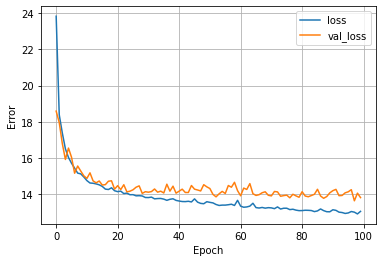

In [53]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    #plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)
plot_loss(history)

In [64]:
compare = np.zeros((test_data.shape[0], num_descriptors, 2))
compare[:,:,0] = test_labels
compare[:,:,1] = model.predict(test_data).reshape((test_data.shape[0],num_descriptors))

avg_l1_error = np.zeros((num_descriptors))

for i,t in enumerate(compare):
    for j,d in enumerate(t):
        avg_l1_error[j] += np.abs(d[0]-d[1])

for i,d in enumerate(avg_l1_error/test_data.shape[0]):
    print(descriptors[i], d)

ACD Descriptors;logP 2.175722251811977

ACD logD-logP;logP 2.108158343066777

MOE Descriptors;h_ema 3.3224984301224723

MOE Descriptors;h_emd 4.532254396181415

MOE Descriptors;h_emd_c 2.042645343658673

MOE Descriptors;h_logp 2.837468623731585

MOE Descriptors;h_logs 2.93867169371579

MOE Descriptors;h_log_dbo 1.6788299963707092

MOE Descriptors;h_log_pbo 1.9858739890466608

MOE Descriptors;h_mr 0.5025098942215575

OEselma Descriptors;bromine_count 1.021538488097702

OEselma Descriptors;carbon_count 4.128358127409852

OEselma Descriptors;clorine_count 0.5200788190406253

OEselma Descriptors;ertl_tpsa 41.30944687992033

OEselma Descriptors;fluorine_count 0.720176883473701

OEselma Descriptors;hba 2.970280602840738

OEselma Descriptors;hba_lipinski 2.5581509375039424

OEselma Descriptors;hbd 1.8966150021503092

OEselma Descriptors;hbd_lipinski 1.9890858133156997

OEselma Descriptors;halogen_count 1.1485958052492133

OEselma Descriptors;iodine_count 0.8940458145492071

OEselma Descriptors;max_flex_chain_1 3.212253316622956

OEselma Descriptors;max_flex_chain_2 1.1683571396550352

OEselma Descriptors;max_flex_chain_3 1.4007692682920687

OEselma Descriptors;max_rigid_chain 4.31336629726617

OEselma Descriptors;mol_volume_2d 99.78202299343697

OEselma Descriptors;mw 70.85359135121605

OEselma Descriptors;npsa 61.73226807945557

OEselma Descriptors;neg_ioniz 1.2774347609450114

OEselma Descriptors;nitrogen_count 1.7589170887254637

OEselma Descriptors;nonpolar_count 4.943950468593137

OEselma Descriptors;nonpolar_count_per_mw 0.4425609203363447

OEselma Descriptors;rigid_frag_count 1.8092333057291765

OEselma Descriptors;aromatic_ring_count 1.0403953792392042

OEselma Descriptors;atom_count 5.082982838753216

OEselma Descriptors;bond_count 5.7931094958129545

OEselma Descriptors;rigid_bond_count 5.646802780365145

OEselma Descriptors;ring_count 1.256986967944566

OEselma Descriptors;rot_bond_count 3.4587611659227053

OEselma Descriptors;oxygen_count 2.0784738191179724

OEselma Descriptors;psa 43.603864630629964

OEselma Descriptors;phosphorous_count 0.6047867230446645

OEselma Descriptors;polar_count 2.612213680453016

OEselma Descriptors;polar_count_per_mw 1.2945718316582755

OEselma Descriptors;pos_ioniz 0.9022194165174522

OEselma Descriptors;silicon_count 0.3538342721476714

OEselma Descriptors;sulphur_count 0.5986249929270577

OEselma Descriptors;tsa 67.05073535429032

Ertl TPSA;Ertl TPSA 41.2223677416174

Exact Mass;Exact Mass 70.7691543544872

Heavy Atom Count;Heavy Atom Count 5.2035407231506685

Molecular Volume (2D);Molecular Volume (2D) 99.77445863548587

Molecular Weight;Molecular Weight 70.86266526973446

NPSA;NPSA 61.74866477398928

PSA;PSA 43.665664669433326

Ring Count;Ring Count 1.1774700216896956

Rotatable Bond Count;Rotatable Bond Count 3.098459633946544

AZlogD74;prediction 2.1689102619145304

AZlogD74;sd_prediction 0.5402244138246749

ChromlogD;prediction 2.638833221897582

ChromlogD;sd_prediction 0.608535817836184

ALogP 2.0389522249930065

Mol Weight 70.83285710531904

Molar Refractivity 17.966832185490816

Polarizability 7.173865779684904

TPSA 42.974090493457936

Solubility DD Class;confidence 0.7068114752263356

Solubility DD Class;credibility 0.4685821892047626

SCScore;SCScore 0.7773295528315963

AZlogD74 (NN);nearest_neighbours[]- GT similarity 1.1385006166623284

AZlogD74 (NN);nearest_neighbours[]- GT measured 1.625606718092902

clogP;clogp 2.3784425835716

clogP;clogp_error 18.660920047094034

OEselma Descriptors;part_flex_chain 2.8357641975002563